In [1]:
import pathlib

import flax
import jax
import jax.numpy as jnp
import numpy as np
import orbax.checkpoint as orbax
from flax import nnx
from jax.sharding import PartitionSpec as P
from rte_dataset.builders import pipeline

from deeprte.configs import default
from deeprte.model import features
from deeprte.model.engine import RteEngine
from deeprte.model.mapping import inference_subbatch
from deeprte.model.modules import (
    BasisFunction,
    BoundaryBasisRepresentation,
    DeepRTE,
    RtePredictor,
)
from deeprte.model.tf import rte_features
from deeprte.train_lib import utils
from deeprte.train_lib.utils import get_abstract_state, init_infer_state

# config = default.Config()

In [2]:
config_path = pathlib.Path("/workspaces/deeprte/ckpts/g0.1-test1127/infer/config.yaml")
config = default.get_config(config_path)

In [3]:
config.load_parameters_path

('/workspaces/deeprte/ckpts/g0.1-test1127/infer/params',
 '/workspaces/deeprte/ckpts/g0.1-test1112/infer/params')

In [4]:
# config.load_parameters_path = (
#     "/workspaces/deeprte/ckpts/g0.1-test1112/infer/params",
#     "/workspaces/deeprte/ckpts/g0.1-test1127/infer/params",
# )

engine = RteEngine(config)


/usr/local/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1591: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [54]:
# data_path = pathlib.Path("/workspaces/deeprte/data/raw_data/train/g0.1/g0.1.npz")
data_path = pathlib.Path(
    "/workspaces/deeprte/data/raw_data/test/source-g0.1-qconstant/g0.1-qconstant.npz"
)
data_pipeline = pipeline.DataPipeline(data_path.parent, [data_path.name])
raw_feature_dict = data_pipeline.process()
del data_pipeline


In [55]:
raw_feature_dict["functions"]["psi_label"].shape

(100, 40, 40, 24)

In [56]:
i = 10

feature_dict = {
    "functions": jax.tree.map(lambda x: x[i : i + 1], raw_feature_dict["functions"]),
    "grid": raw_feature_dict["grid"],
    "shape": raw_feature_dict["shape"],
}


In [57]:
processed_feature_dict = engine.process_features(feature_dict)

In [58]:
prediction = engine.predict(processed_feature_dict)

In [59]:
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from absl import logging
from matplotlib.colors import ListedColormap
from rte_dataset.builders import pipeline


def plot_phi(r, phi_pre, phi_label):
    fig, _axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    fig.subplots_adjust(hspace=0.3)
    axs = _axs.flatten()

    viridis = matplotlib.colormaps["viridis"](np.linspace(0, 1.2, 128))
    cs_1 = axs[0].contourf(
        r[..., 0], r[..., 1], phi_label, cmap=ListedColormap(viridis)
    )
    axs[0].set_title(r"Exact $f(x,v)$", fontsize=20)
    axs[0].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_1)
    cbar.ax.tick_params(labelsize=16)

    cs_2 = axs[1].contourf(r[..., 0], r[..., 1], phi_pre, cmap=ListedColormap(viridis))
    axs[1].set_title(r"Predict $f(x,v)$", fontsize=20)
    axs[1].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_2)
    cbar.ax.tick_params(labelsize=16)

    cs_3 = axs[2].contourf(
        r[..., 0],
        r[..., 1],
        abs(phi_pre - phi_label),
        cmap=ListedColormap(viridis),
    )
    axs[2].set_title(r"Absolute error", fontsize=20)
    axs[2].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_3)
    cbar.ax.tick_params(labelsize=16)

    plt.tight_layout()


In [60]:
def rmse(pred, target):
    return jnp.sqrt(jnp.mean((pred - target) ** 2) / jnp.mean(target**2))


rmse(prediction, feature_dict["functions"]["psi_label"].reshape(1, -1))


Array(0.23582599, dtype=float32)

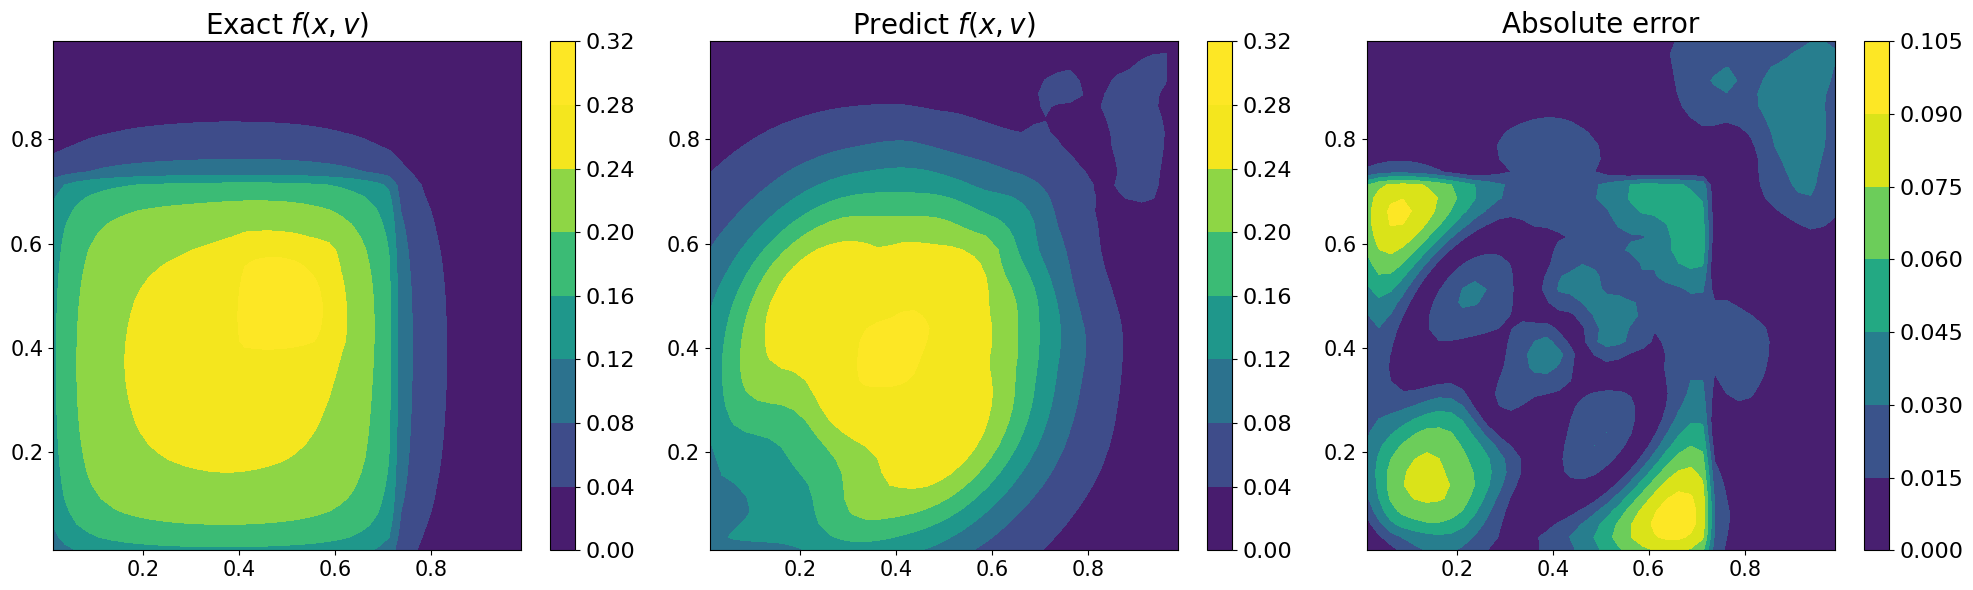

In [61]:
plot_phi(
    feature_dict["grid"]["position_coords"],
    prediction.reshape(40, 40, 24) @ feature_dict["grid"]["velocity_weights"],
    feature_dict["functions"]["psi_label"].reshape(40, 40, 24)
    @ feature_dict["grid"]["velocity_weights"],
)
